<img src="images/eaglegraph.png" alt="Profile Graph" style="width: 400px;float: right;margin: 10pt"/>

# DDPAlgorithms Tutorial

This tutorial will cover the proper use of the functions included in <code>algorithms/homology.py</code>

## Part 1: The DDP Profile Graph

When we use the DeepDataProfiler to investigate a Model-Data pairing, the result is a Profile describing influential synapses and neurons. A Profile can be interpreted as a weighted directed graph, where the neurons are the nodes and the synapses are the edges. We believe that these weighted graph representations of influential decision paths have the potential to provide a window of interpretability into DNNs

First, we will go over the steps required to construct a graph representation of a Profile, and then we will plot visualization organized by layer.

### Import packages and load a Profile

In [1]:
import pickle
import deep_data_profiler as ddp
import torchvision.models.vgg as vgg
import torchvision.models.resnet as resnet
import networkx as nx
import numpy as np
import math as math
import matplotlib.pyplot as plt
from persim import plot_diagrams

For this example we will use a channel-wise profile of an eagle image from the ImageNet dataset on a pretrained ResNet-18 architecture.<br/>
(The Profile Graph for the same image on a pretrained VGG16 architecture is pictured above)

In [2]:
profile = pickle.load(open('algorithms_data/resnet_eagleprofile.p','rb'))

### Generate a dictionary view of the Profile
In order to reconstruct all the data necessary to properly create the Profile Graph, we need to put the Profile in a dictionary format. To do this, we need to use a <code>TorchProfiler</code> of the model used to create the Profile, so <b>make sure you have the original model, as it is required for the creation of the dictionary view and Profile Graph.</b> 
    
This example uses a ResNet-18 architecture, so we will initialize the appropriate model and profiler, and then construct the dictionary view of the profiler using the <code>dict_view()</code> function.

In [3]:
model = resnet.resnet18(pretrained=True).eval()
profiler = ddp.TorchProfiler(model)

In [4]:
profile_dict = profiler.dict_view(profile)

### Construct the Profile Graph

<b>Step 1: Create a list of edges using <code>ddp.tuples_from_dict()</code></b>, which takes the <code>synapse_weights</code> of the dictionary-formatted Profile and returns a list of 3-tuples, each representing $(neuron_{1}, neuron_{2}, weight)$ for a synapse.

In [5]:
T = ddp.tuples_from_dict(profile_dict.synapse_weights)

The first two entries of each edge tuple are both 2-tuples which represent neurons, or nodes in the graph. A neuron tuple $(L, idx)$ represents a neuron at $idx$ position within layer $L$. For a channel-wise profile $idx$ will be a channel in layer $L$, and for an element-wise profile $idx$ will be the 1D flattened index of an element in layer $L$.

In [6]:
# Print the first 10 edges in T
T[:10]

[((0, 1), (1, 24), 1.0),
 ((0, 1), (1, 39), 1.0),
 ((0, 1), (1, 41), 1.0),
 ((1, 24), (2, 24), 1.0),
 ((1, 39), (2, 39), 1.0),
 ((1, 41), (2, 41), 1.0),
 ((2, 25), (3, 42), 0.49396166),
 ((2, 50), (3, 42), 0.5060383),
 ((2, 40), (3, 60), 0.5415584),
 ((2, 41), (3, 60), 0.45844162)]

<b>Step 2: Create the Profile Graph using <code>ddp.graph_from_tuples()</code></b>, which takes the list of tuples generated in Step 1 and returns a NetworkX graph

In [7]:
G = ddp.graph_from_tuples(T)

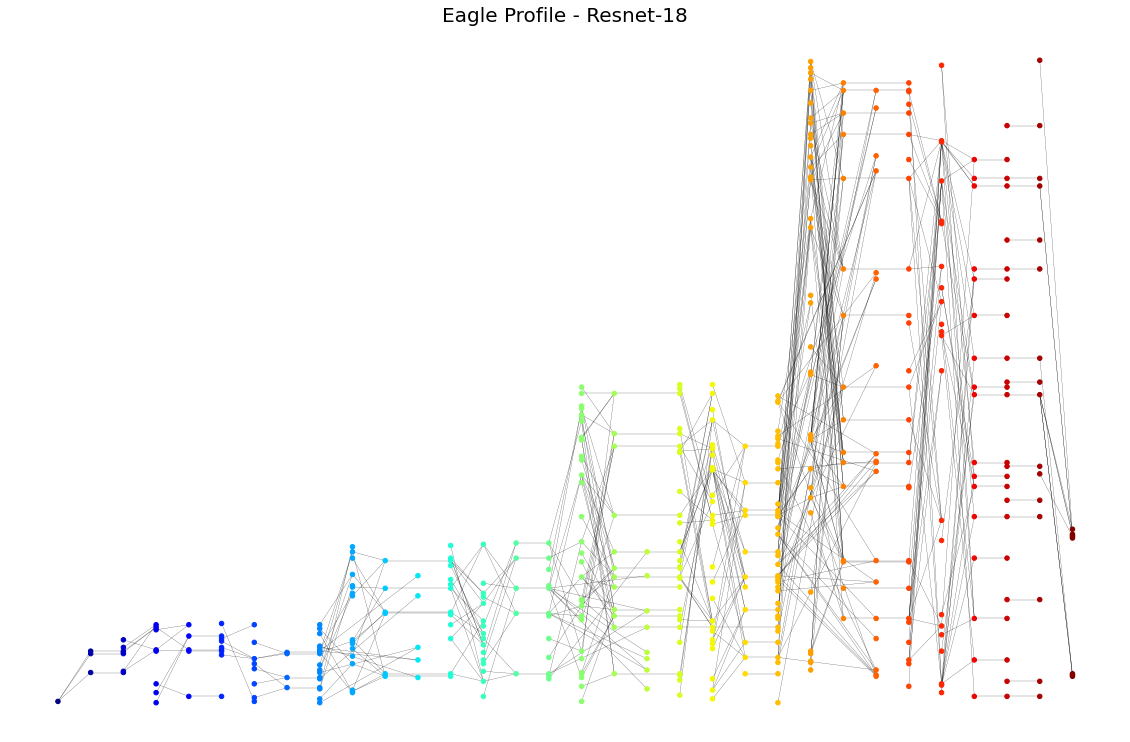

In [8]:
fig, ax = plt.subplots(figsize=(20,13))
ax.axis('off')
# position nodes by layer and index
position = {node:(node[0],node[1]) for node in G.nodes}
ax.set_title('Eagle Profile - Resnet-18', fontsize=20)
nx.draw(G,ax=ax,node_size=20,width=0.2, node_color=[v[0] for v in G.nodes], cmap='jet', pos=position, arrows=False)


<img src="images/homologyimg.png" alt="Barcode Example" style="width: 500px;float: right;margin: 15pt"/>

## Part 2: Persistent Homology
<br/>

<!-- <img src="notebook_images/homologyimg.png" alt="Barcode Example" style="width: 500px;float: left;margin: 15pt"/> -->
<center><i>"Data has shape, and that shape has meaning" - Gunnar Carlsson</i></center>

Once we have constructed a Profile Graph, persistent homology is one of the tools we can use to interrogate its structure. Persistent homology requires a point cloud or arbitrary metric space. To compute persistent homology of a profile graph, we first create a metric space on the vertices of the graph using a metric like shortest path distance or a function of shortest path distance. Then we use the ripser package to compute the persistent homology of a Vietoris-Rips filtration of the metric space. This will act as a signature for the structural features of the graph.

We will show how to apply a custom weighting scheme to a Profile Graph, how to create a distance matrix using a custom distance kernel for the filtration, and how to calculate persistent homology and plot the resulting persistence diagram.

### Profile Graph weighting schemes

By default, the weight of an edge in a Profile Graph is equal to the weight of the corresponding synapse in the original Profile. However, by passing an optional weight function argument to <code>ddp.graph_from_tuples()</code>, we can set a function of the synapse weight as the weighting scheme. 

One example of a weighting scheme that can be useful when analyzing a Profile Graph is an "inverted" weighting scheme, $f(x) = 1/x$. When we are computing persistent homology, points that are "close together" in the filtration are connected first. Intuitively, the greater the weight of the synapse, the "closer" we might want the neurons it connects to be in the filtration - so that the most influential synapses will be the first edges to appear in the Vietoris-Rips complex.

In [9]:
inverted_weights = lambda x: 1/x
G = ddp.graph_from_tuples(T, weight_func=inverted_weights)

In [10]:
# observe the inversion of the weights for a sample edge
print(f'edge: {T[10][:2]}')
print(f'weight in the original graph: {T[10][-1]}')
print(f'weight in the inverted graph: {G[T[10][0]][T[10][1]]["weight"]}')

edge: ((2, 25), (3, 62))
weight in the original graph: 0.5363399386405945
weight in the inverted graph: 1.8644891568854576


### Distance matrices and filtration kernels

Once we have an appropriately weighted graph, the next step is to construct the distance matrix for the filtration using <code>ddp.mat_from_graph()</code>. By default, the shortest path distance is used, but we can also specify a function of shortest path distance to use as the kernel. 

In [11]:
# Use the shortest path (SP)
SP_distmat = ddp.mat_from_graph(G)

One example of a custom kernel is the Gaussian kernel, given by $g(x)=1-\exp(-x/2\sigma)$, where $\sigma$ is the standard deviation of the finite shortest path distances. $g(x)$ is an increasing function that spreads out the low distances and contracts the high distances. In the case of inverted weights, the low distances correspond to the most influential connections, and so spreading out the low distances can help see the more nuanced structures that emerge at those distance thresholds.

In [12]:
# Apply the Gaussian kernel (GAU) to transform the shortest path between vertices.
sigma = np.std(SP_distmat[np.isfinite(SP_distmat)])
gaussian = (lambda x : 1 - math.exp(-x / (2 * sigma)))
GAU_distmat = ddp.mat_from_graph(G, kernel=gaussian)

### Computing persistence

The final step is to compute the persistence on the filtration distance matrix using <code>ddp.ripser_of_distmat()</code>, which uses the <code>ripser</code> package for persistent homology.

In [13]:
# Compute homology for both kernels
SP_rips = ddp.ripser_of_distmat(SP_distmat)
GAU_rips = ddp.ripser_of_distmat(GAU_distmat)

Persistence diagrams allow us to visualize the persistence of features by plotting a point for each feature whose coordinates are $(birth, death)$. The $birth$ of a feature like an open loop represents the time in the filtration when the loop was formed, and the $death$ represents the time when the loop was closed or triangulated. For this example, we calculated the 0- and 1-dimensional homology, $H_0$ and $H_1$. The blue points in the persistence diagram correspond to 0-dimensional features, which are connected components, and the orange points correspond to 1-dimensional features, which are open loops.

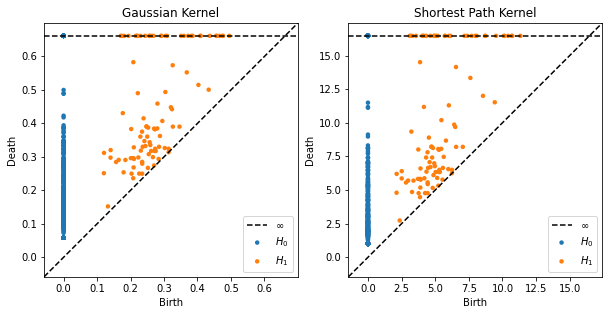

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title('Gaussian Kernel')
plot_diagrams(GAU_rips['dgms'], ax=ax[0])
ax[1].set_title('Shortest Path Kernel')
plot_diagrams(SP_rips['dgms'], ax=ax[1])

### For a more in depth introduction to persistent homology ...

[A User’s Guide to Topological Data Analysis](https://learning-analytics.info/index.php/JLA/article/view/5196) by Elizabeth Munch gives an overview of modern TDA methods, including persistent homology (Section 3).